In [1]:
import os
from glob     import glob
from datetime import datetime

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

from CCdb   import _default_reference_file as references

from CCio   import load_hdf

from CCcore import rebin_df
from CCcore import filter_df
from CCcore import histogram
from CCcore import integrate_peak
from CCcore import power_to_quanta_rate

from CCfit  import fit
from CCfit  import gauss

from CCplot import change_jupyter_width
from CCplot import auto_plot_style
from CCplot import figure
from CCplot import subplot
from CCplot import labels
from CCplot import normhist
from CCplot import plot1d
from CCplot import plot2d

In [2]:
exec(change_jupyter_width(90))

In [3]:
%matplotlib inline

auto_plot_style()

In [4]:
_default_column = "rate"

In [5]:
def remove_duplicate_grating(df):
    sel = (df.ex_wl == 400) & (df.grating_mono == 1)
    return df.loc[~sel].reset_index(drop=True)

def correct_power(data):
    for _, df in data.groupby("date ex_wl grating_mono".split()):
        powers   = df.power0.unique()
        replace  = df.power0 < 3e-9
        replace |= df.power0.isna()

        data.loc[df.loc[replace].index, "power0"] = np.nanmax(powers)

    data.loc[:, "dq0"] = data.rate / power_to_quanta_rate(data.power0, data.ex_wl)

def plot_comparison_2d(dfs, exposure, column=_default_column):
    figure(3)
    n = 1
    for label, df in enumerate(dfs):
        subplot(3, n); n+=1
        df = filter_df(df, exposure=exposure)
        df = remove_duplicate_grating(df)
        spectrum = getattr(df, column)
        s, c = plot2d(df.ex_wl, df.em_wl, spectrum, title=str(label)
                     , log=True, zlabel=column
                     , cmin=np.percentile(spectrum, 5), cmax=spectrum.max())

    subplot(3, n); n+=1
    df1 = filter_df(remove_duplicate_grating(df1), exposure=exposure)
    df2 = filter_df(remove_duplicate_grating(df2), exposure=exposure)

    spectrum = getattr(df2, column).values - getattr(df1, column).values
    s, c = plot2d(df1.ex_wl, df1.em_wl, spectrum, title="diff"
                 , zlabel=column
                 , cmin=-5, cmax=np.percentile(spectrum, 99))
    

    plt.tight_layout()

def plot_comparison_1d_array(dfs, exposure, column=_default_column):
    plt.figure(figsize=(6*4, 3*14))
    n   = len(dfs)
    dfs = map(remove_duplicate_grating, dfs)
    for label, df in enumerate(dfs):
        for ex_wl, data in filter_df(df, exposure=exposure).groupby("ex_wl"):
            plt.subplot(14, 4, (ex_wl - 240) // 10)
            spectrum = getattr(data, column)
            plot1d(data.em_wl, spectrum, title=str(ex_wl), ylabel=column, label=label)

            if label==n-1:
                plt.fill_betweenx(plt.ylim(), ex_wl - 10, ex_wl + 10, color="y", alpha=0.5)
                if ex_wl == 250:
                    plt.legend()

            wlmin = np.round(data.em_wl.min(), -2)
            wlmax = np.round(data.em_wl.max(), -2) + 1
            ticks = np.concatenate([ np.arange(wlmin, 1000, 200)
                                   , np.arange(1000, wlmax, 200)])

            plt.xticks(ticks)
    plt.tight_layout()

In [6]:
folder = "/home/gonzalo/data/CC/pre-annealing-experiment/"

caf_filename_0 = os.path.join(folder, "scan_postanneal_CaF_B3_400_2021_04_19_15_06_33_525000.h5")
baf_filename_0 = os.path.join(folder, "scan_postanneal_BaF_B3_420_2021_04_20_12_53_55_002000.h5")
qtz_filename_0 = os.path.join(folder, "scan_postanneal_Qz_B3_440_2021_04_25_15_55_14_950000.h5" )
lif_filename_0 = os.path.join(folder, "scan_postanneal_LiF_B3_460_2021_04_26_12_24_16_791000.h5")
mgf_filename_0 = os.path.join(folder, "scan_postanneal_MgF_B3_480_2021_04_26_20_49_45_884000.h5")

caf_filename_1  = os.path.join(folder, "scan_irrad1_CaF_B3_400_2021_05_04_12_39_56_423000.h5")
baf_filename_1  = os.path.join(folder, "scan_irrad1_BaF_B3_420_2021_05_05_14_36_49_219000.h5")
qtz_filename_1  = os.path.join(folder, "scan_irrad1_Qz_B3_440_2021_05_10_12_06_42_598000.h5" )
lif_filename_1  = os.path.join(folder, "scan_irrad1_LiF_B3_460_2021_05_06_12_05_09_231000.h5")
mgf_filename_1  = os.path.join(folder, "scan_irrad1_MgF_B3_480_2021_05_11_14_16_45_448000.h5")

#caf_filename_2  = os.path.join(folder, "scan_irrad1_CaF_B3_400_2021_05_04_12_39_56_423000.h5")
baf_filename_2  = os.path.join(folder, "scan_irrad2_BaF_B3_420_2021_05_20_16_36_41_679000.h5")
#qtz_filename_2  = os.path.join(folder, "scan_irrad1_Qz_B3_440_2021_05_10_12_06_42_598000.h5" )
lif_filename_2  = os.path.join(folder, "scan_irrad2_LiF_B3_460_2021_05_13_14_23_57_501000.h5")
#mgf_filename_2  = os.path.join(folder, "scan_irrad1_MgF_B3_480_2021_05_11_14_16_45_448000.h5")

In [7]:
caf_0 = load_hdf(caf_filename_0, "CaF"); correct_power(caf_0)
baf_0 = load_hdf(baf_filename_0, "BaF"); correct_power(baf_0)
qtz_0 = load_hdf(qtz_filename_0,  "Qz"); correct_power(qtz_0)
lif_0 = load_hdf(lif_filename_0, "LiF"); correct_power(lif_0)
mgf_0 = load_hdf(mgf_filename_0, "MgF"); correct_power(mgf_0)

caf_1 = load_hdf(caf_filename_1, "CaF"); correct_power(caf_1)
baf_1 = load_hdf(baf_filename_1, "BaF"); correct_power(baf_1)
qtz_1 = load_hdf(qtz_filename_1,  "Qz"); correct_power(qtz_1)
lif_1 = load_hdf(lif_filename_1, "LiF"); correct_power(lif_1)
mgf_1 = load_hdf(mgf_filename_1, "MgF"); correct_power(mgf_1)

#caf_2 = load_hdf(caf_filename_2, "CaF"); correct_power(caf_2)
baf_2 = load_hdf(baf_filename_2, "BaF"); correct_power(baf_2)
#qtz_2 = load_hdf(qtz_filename_2,  "Qz"); correct_power(qtz_2)
lif_2 = load_hdf(lif_filename_2, "LiF"); correct_power(lif_2)
#mgf_2 = load_hdf(mgf_filename_2, "MgF"); correct_power(mgf_2)

crystals = dict( caf_0 = caf_0
               , baf_0 = baf_0
               , qtz_0 = qtz_0
               , lif_0 = lif_0
               , mgf_0 = mgf_0
               
               , caf_1 = caf_1
               , baf_1 = baf_1
               , qtz_1 = qtz_1
               , lif_1 = lif_1
               , mgf_1 = mgf_1

#               , caf_2 = caf_2
               , baf_2 = baf_2
#               , qtz_2 = qtz_2
               , lif_2 = lif_2
#               , mgf_2 = mgf_2
               )

# CaF

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


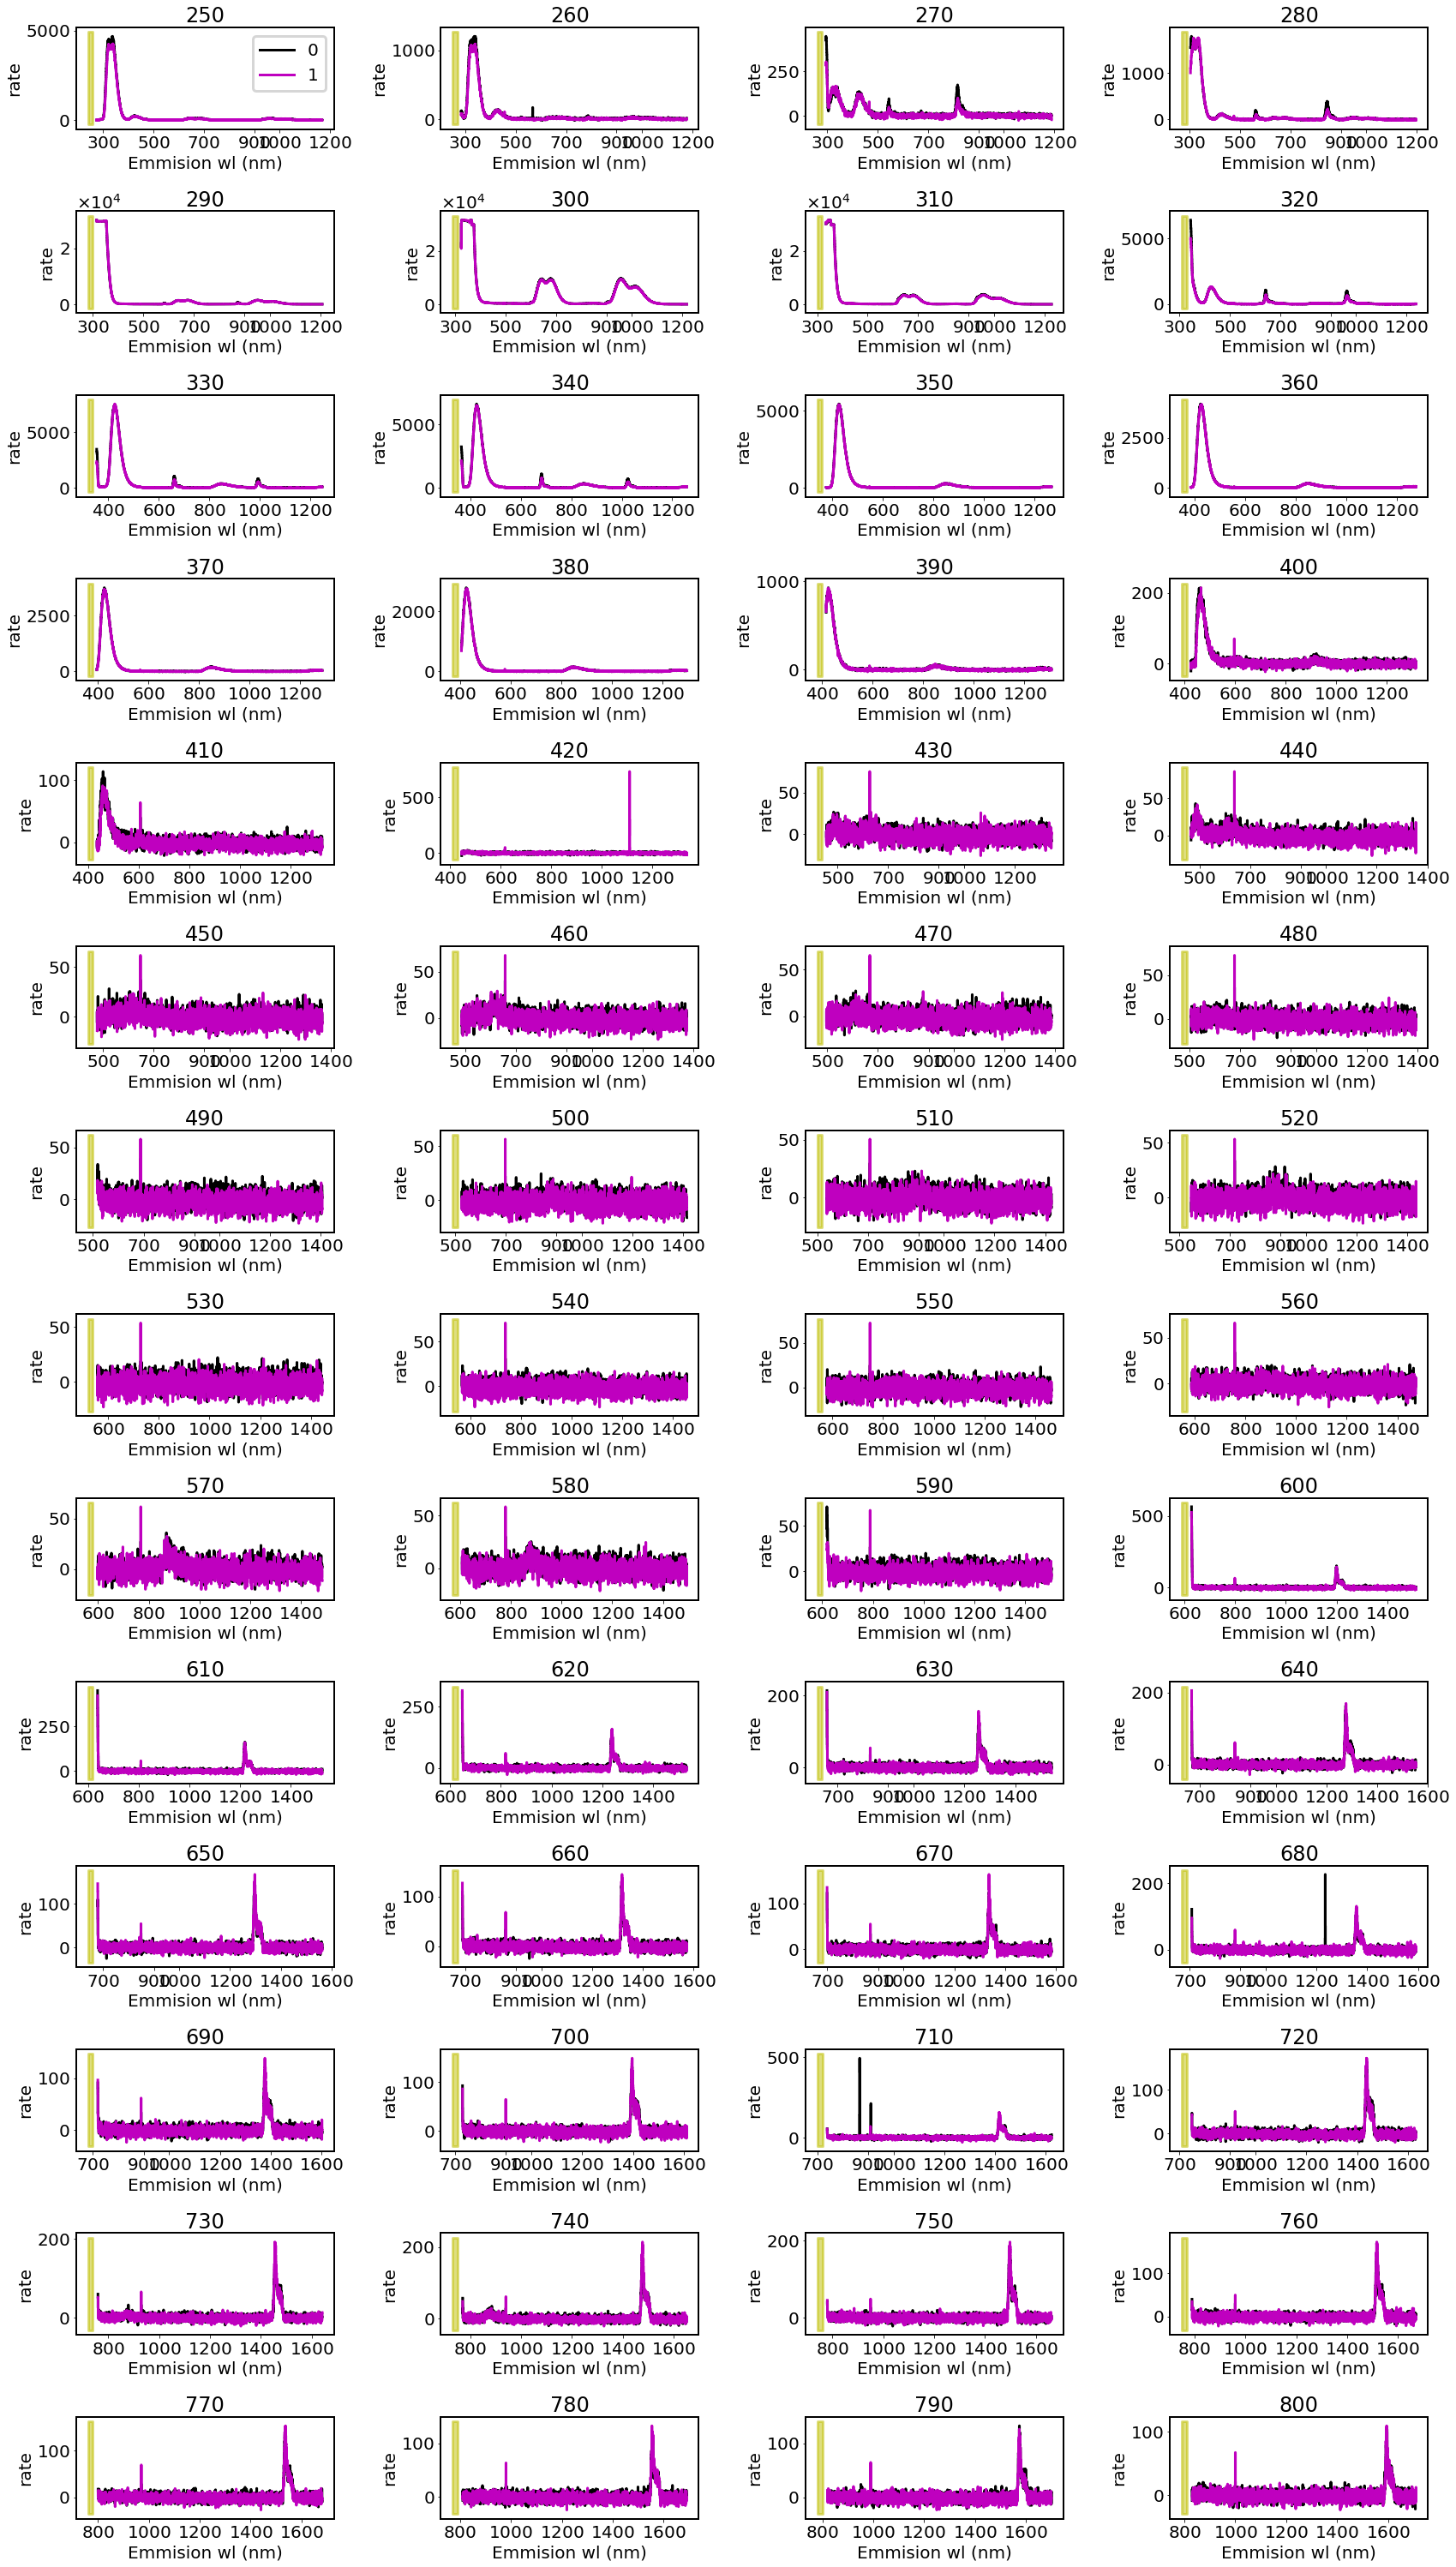

In [8]:
plot_comparison_1d_array([caf_0, caf_1], 2)

# BaF

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


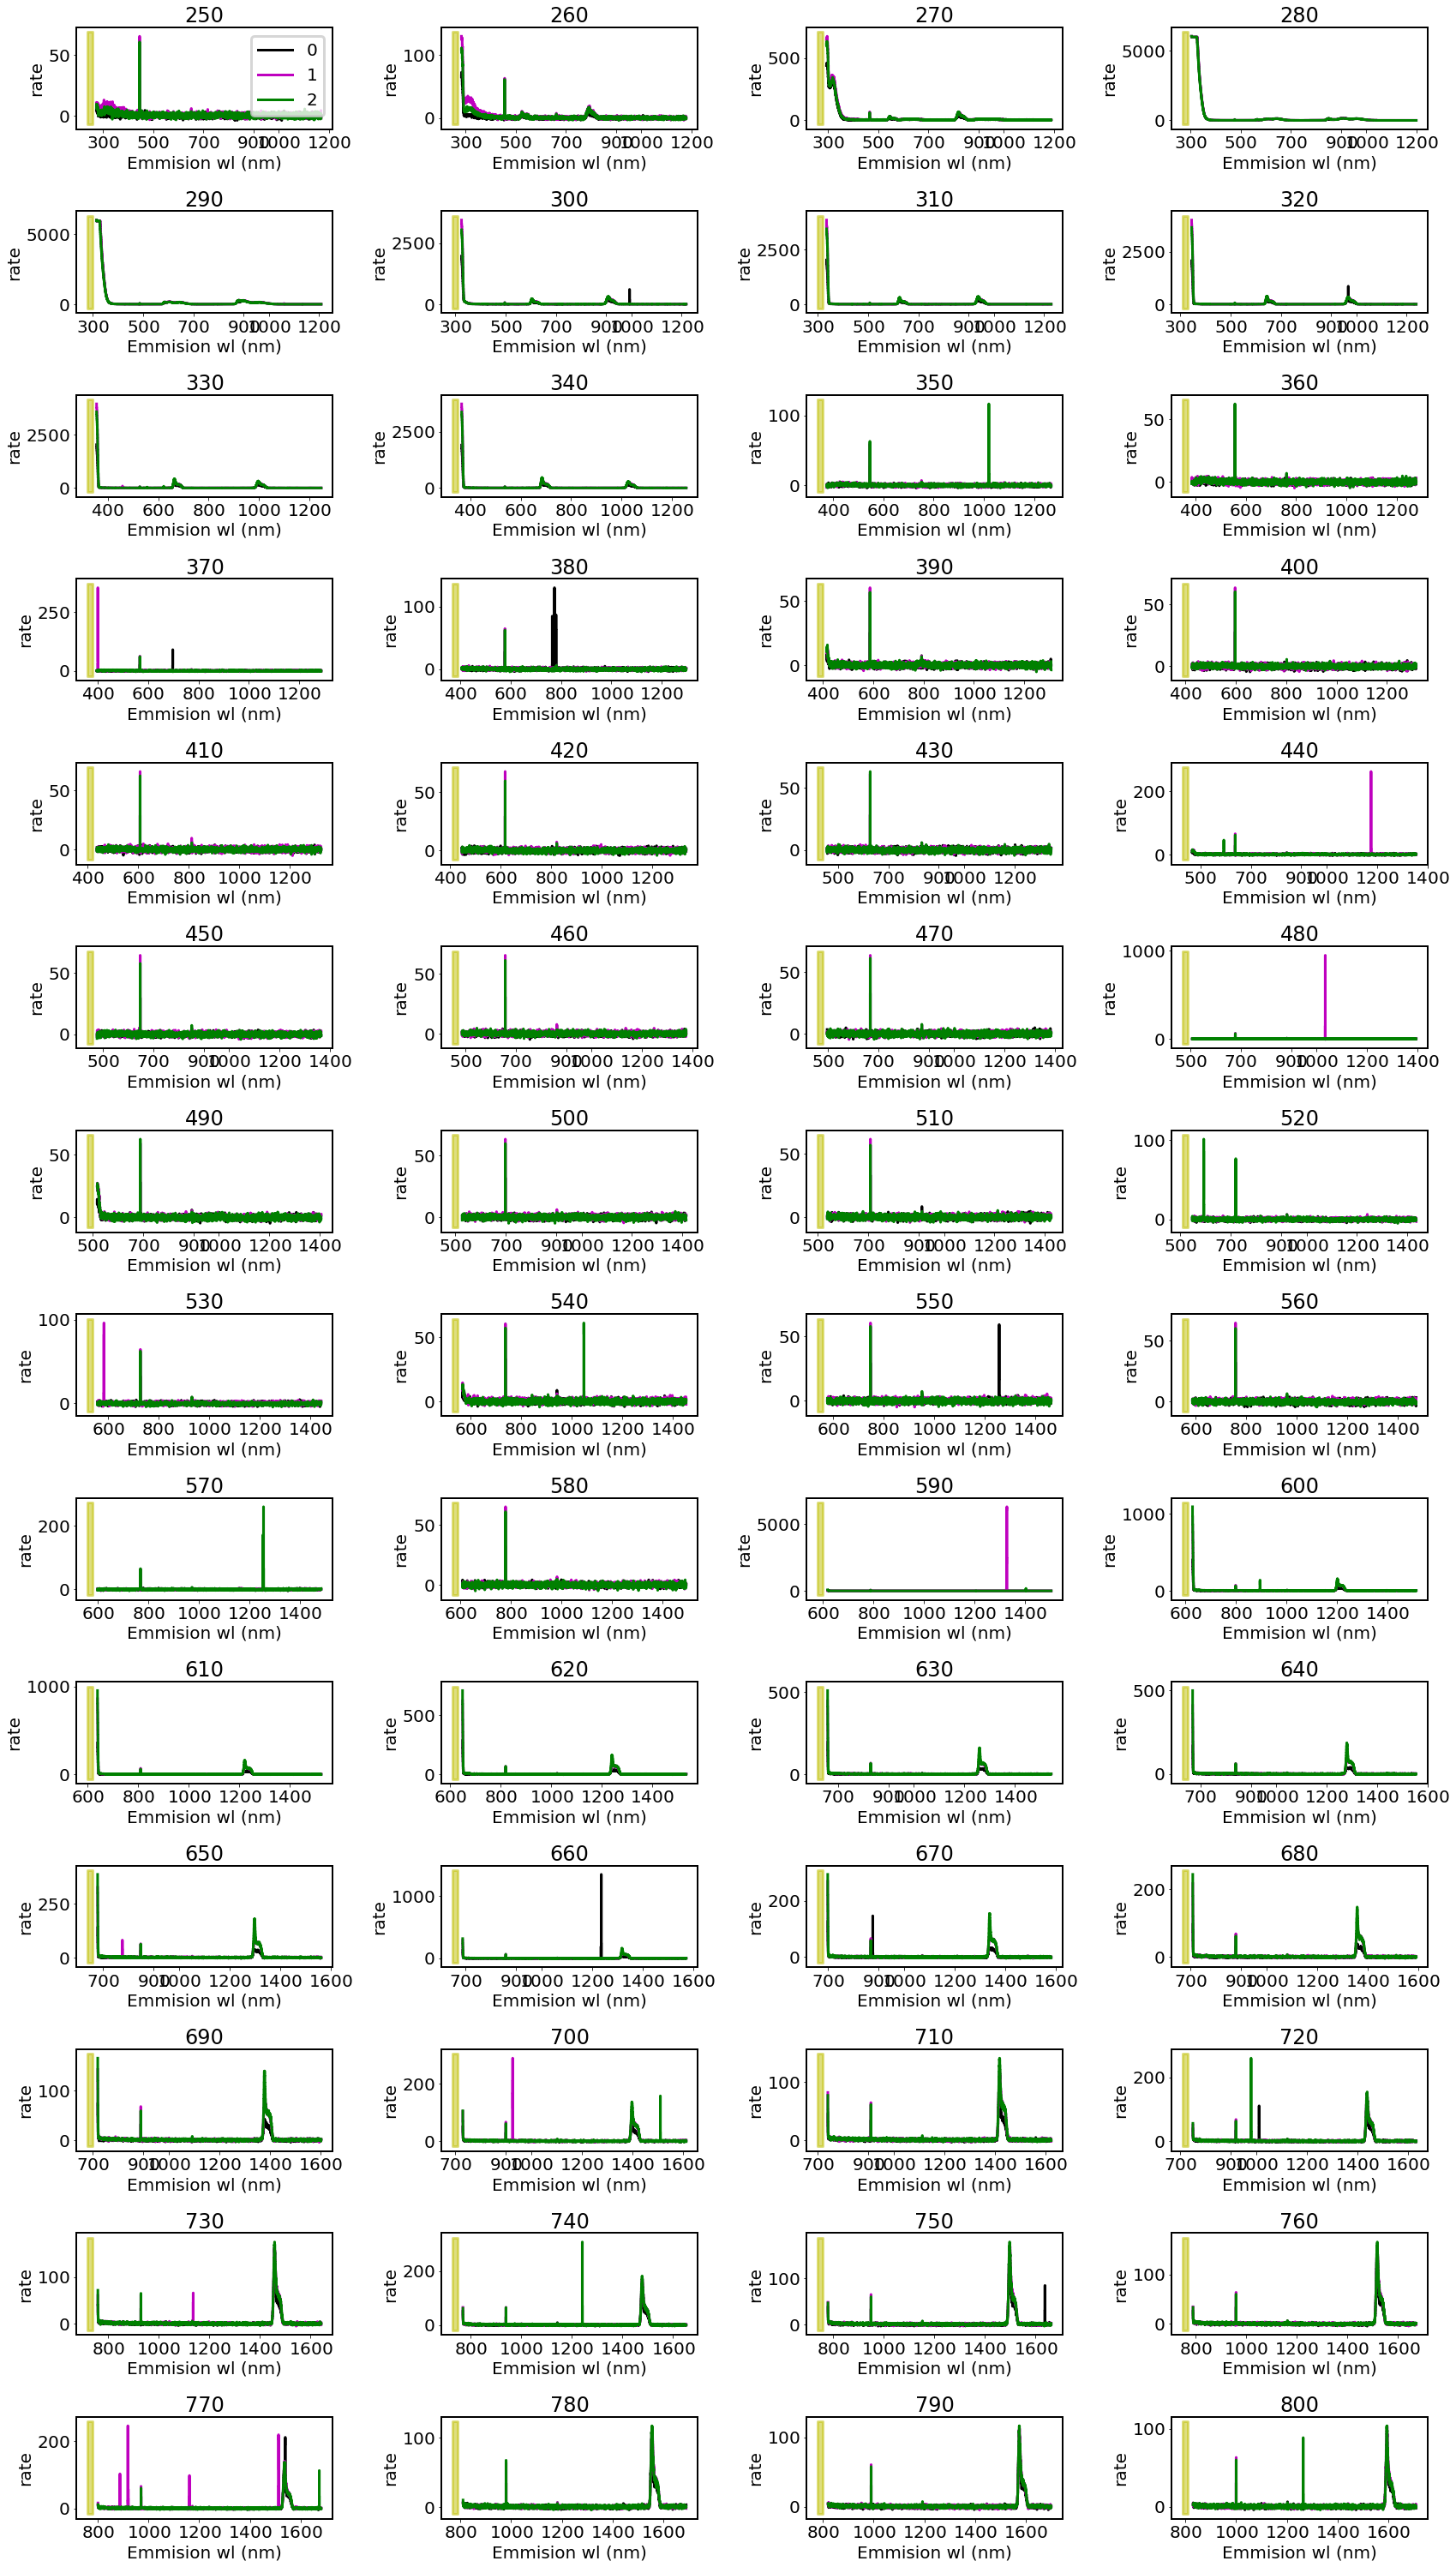

In [9]:
plot_comparison_1d_array([baf_0, baf_1, baf_2], 10)

# Qz

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


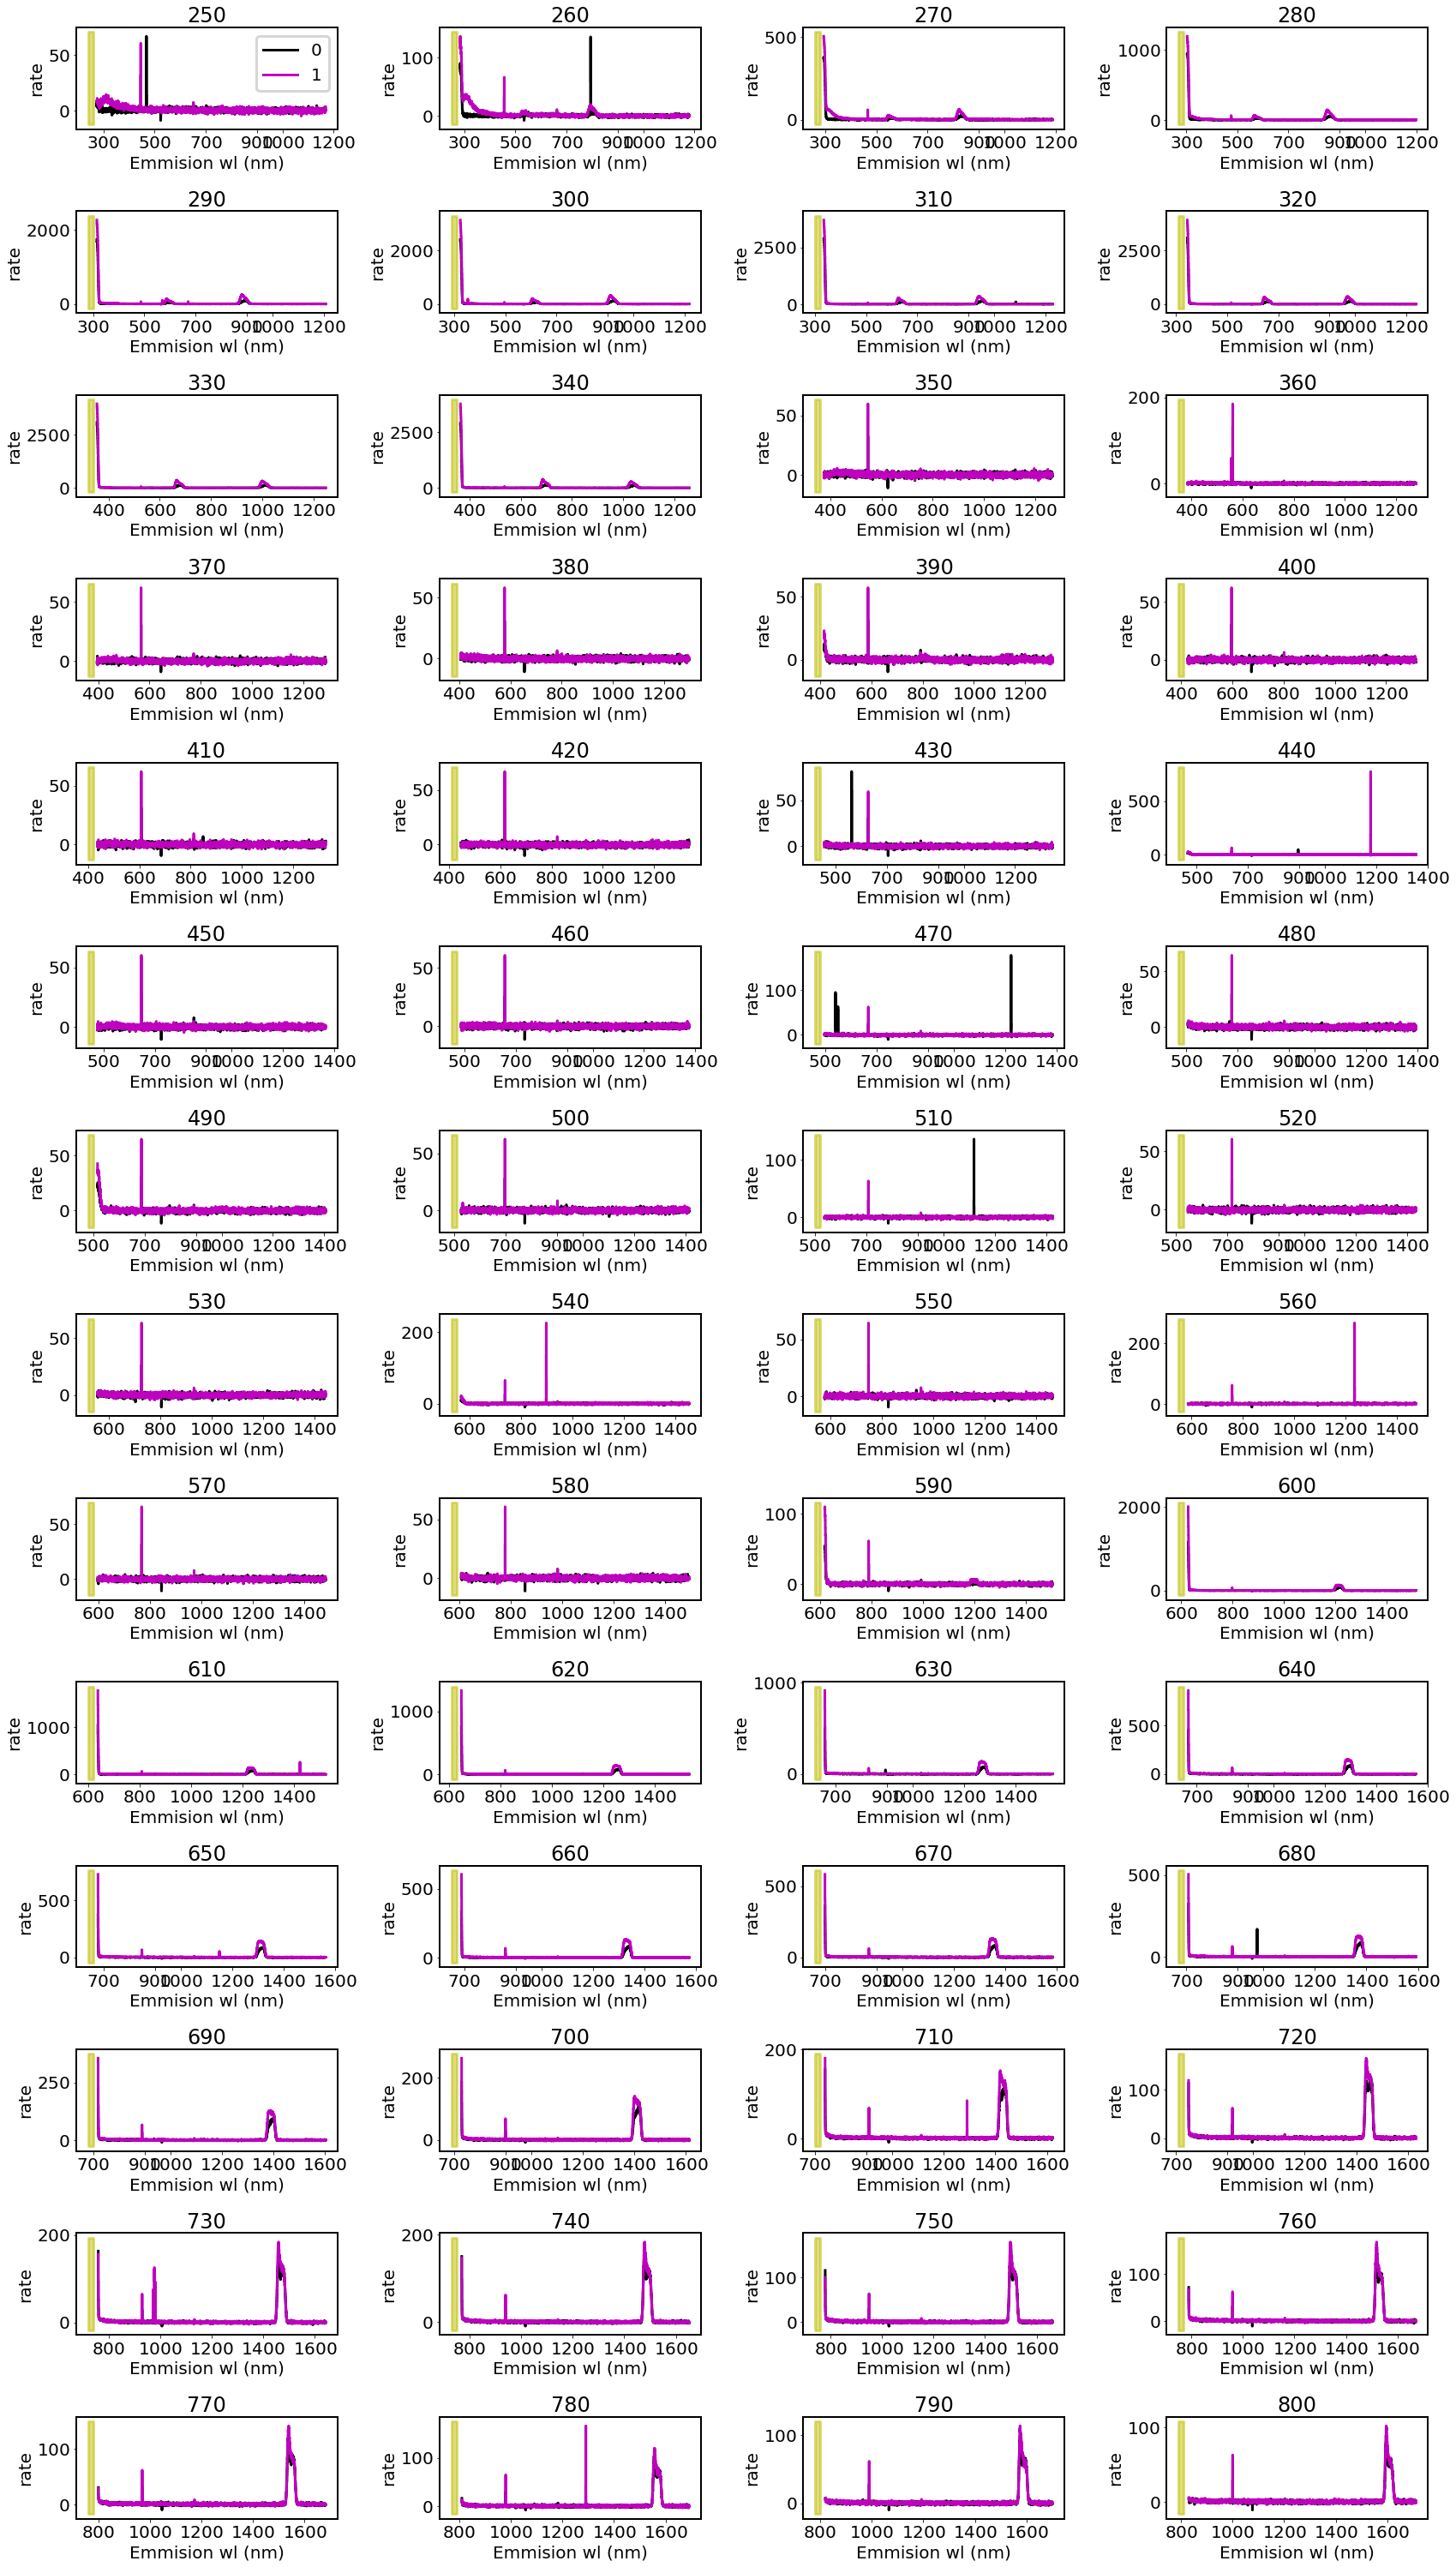

In [10]:
plot_comparison_1d_array([qtz_0, qtz_1], 10)

# LiF

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


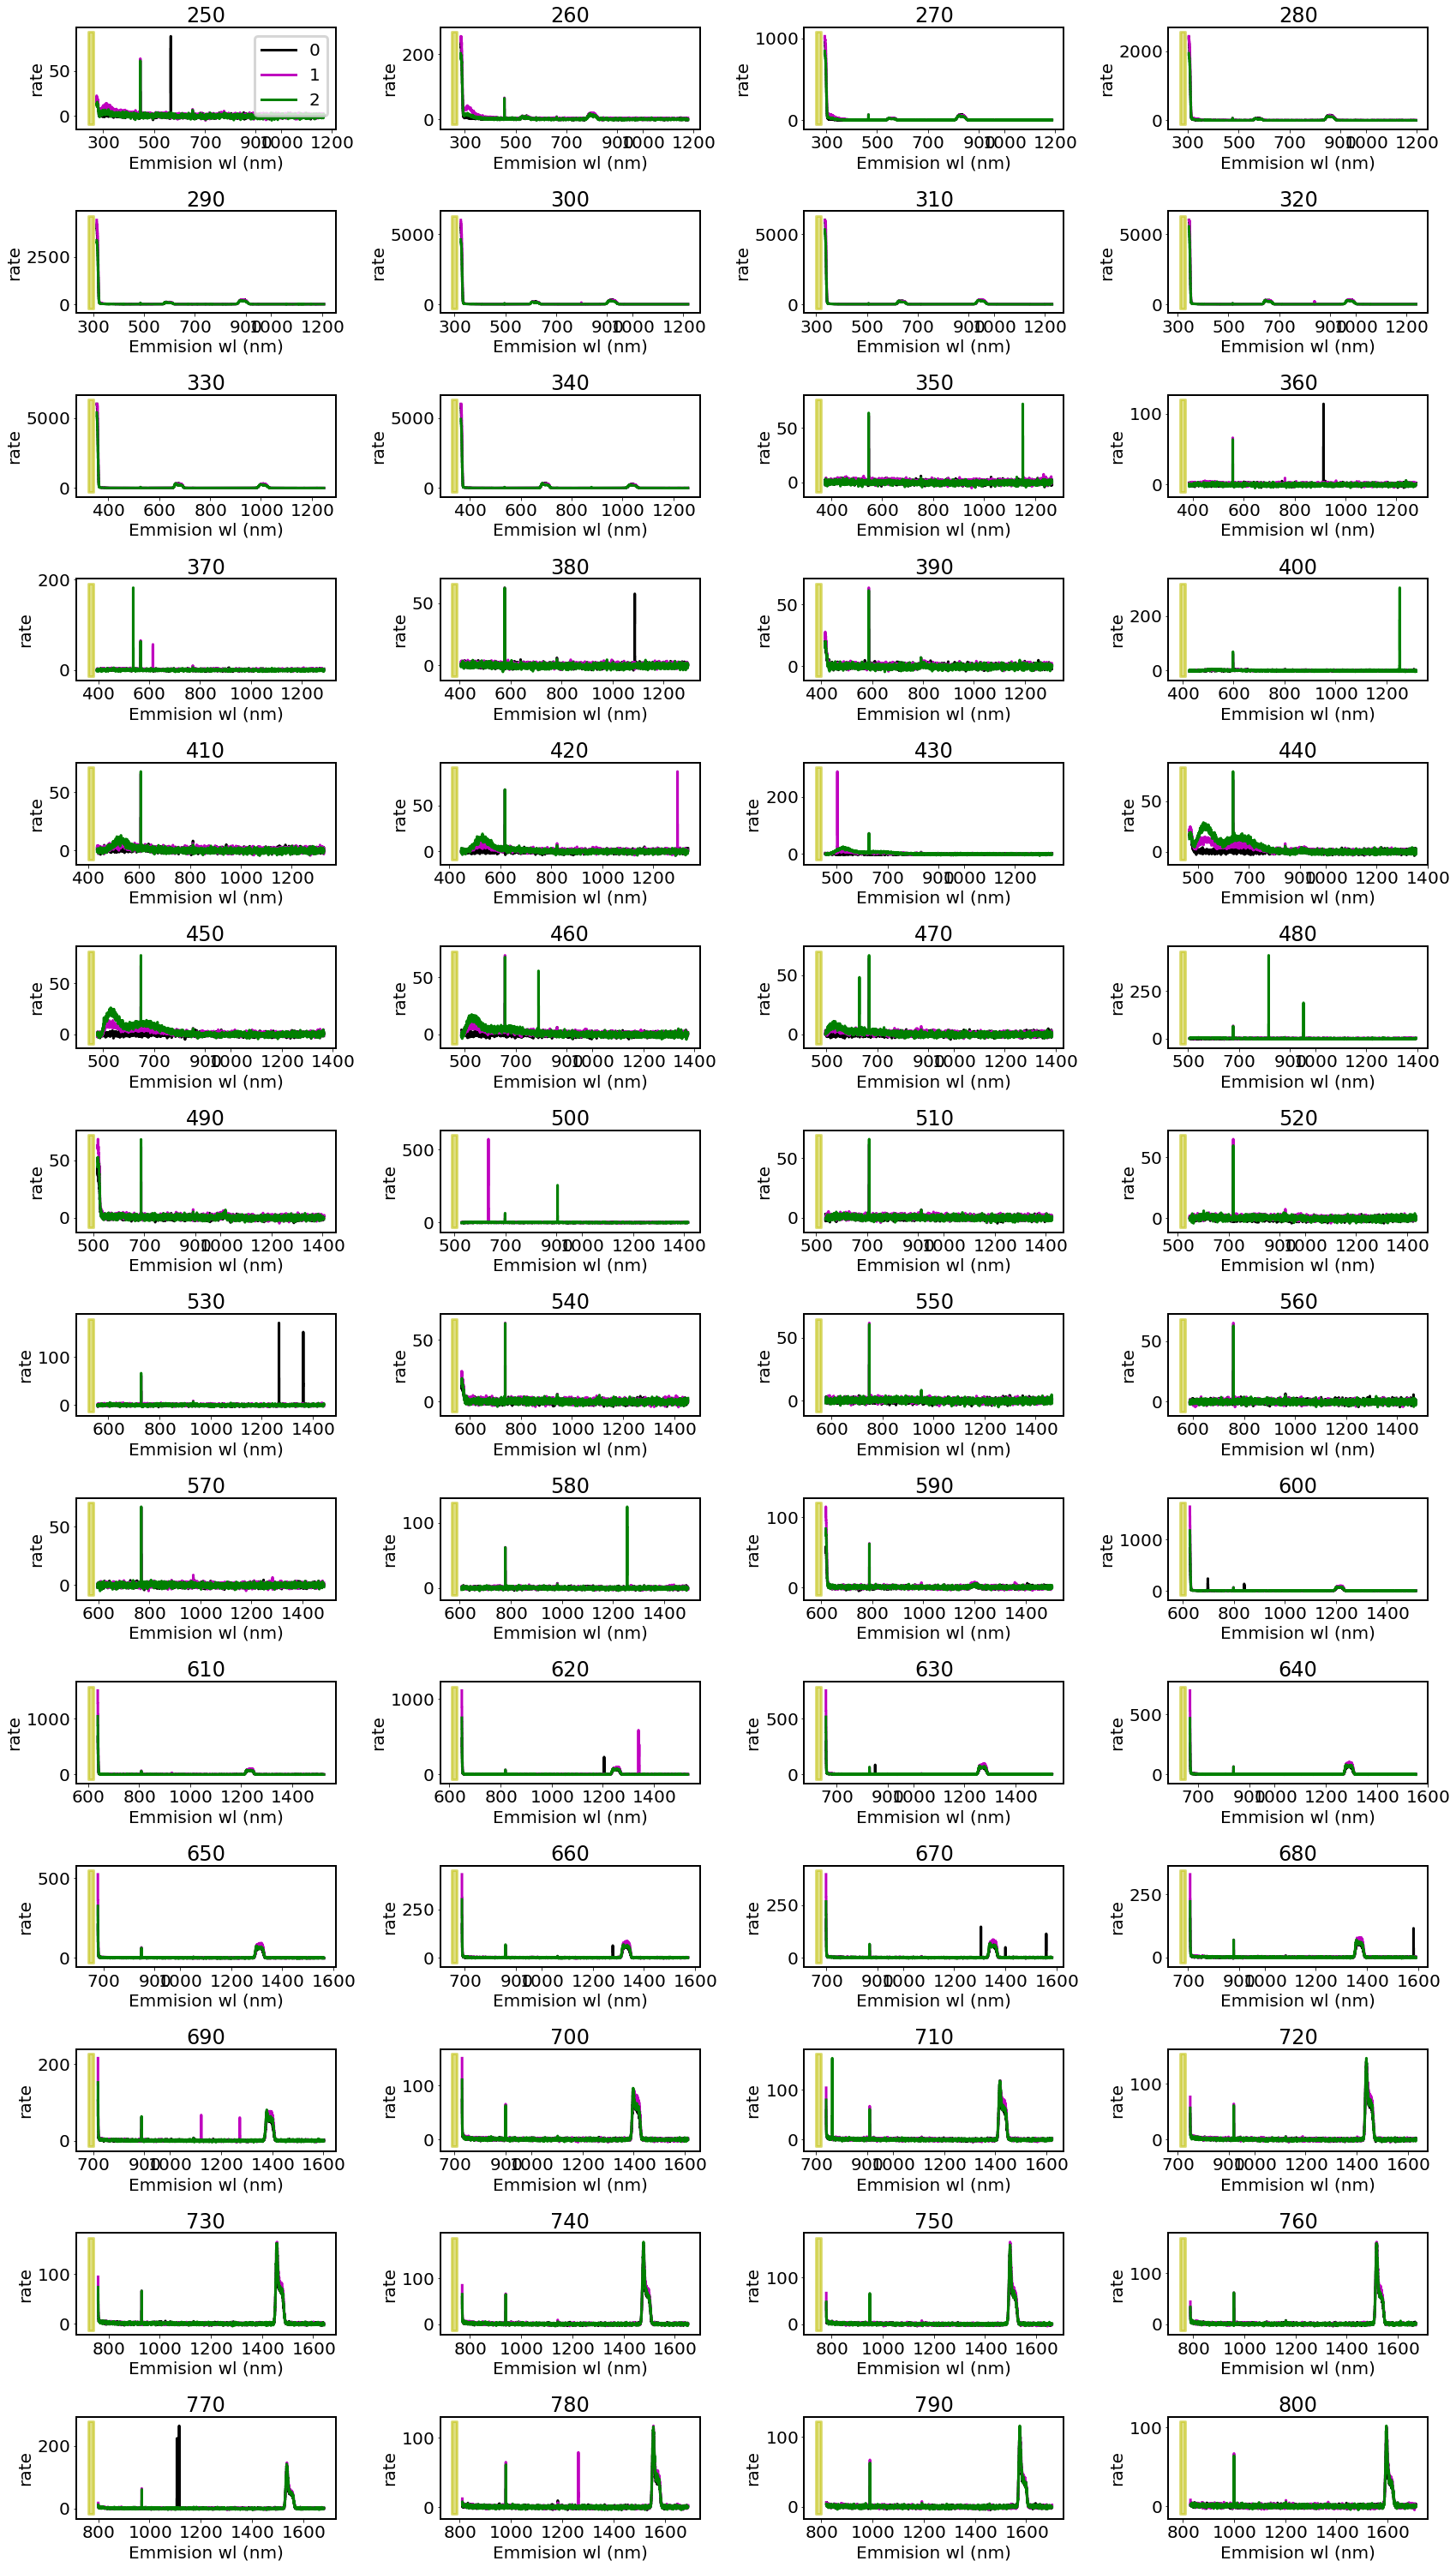

In [11]:
plot_comparison_1d_array([lif_0, lif_1, lif_2], 10)

# MgF

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


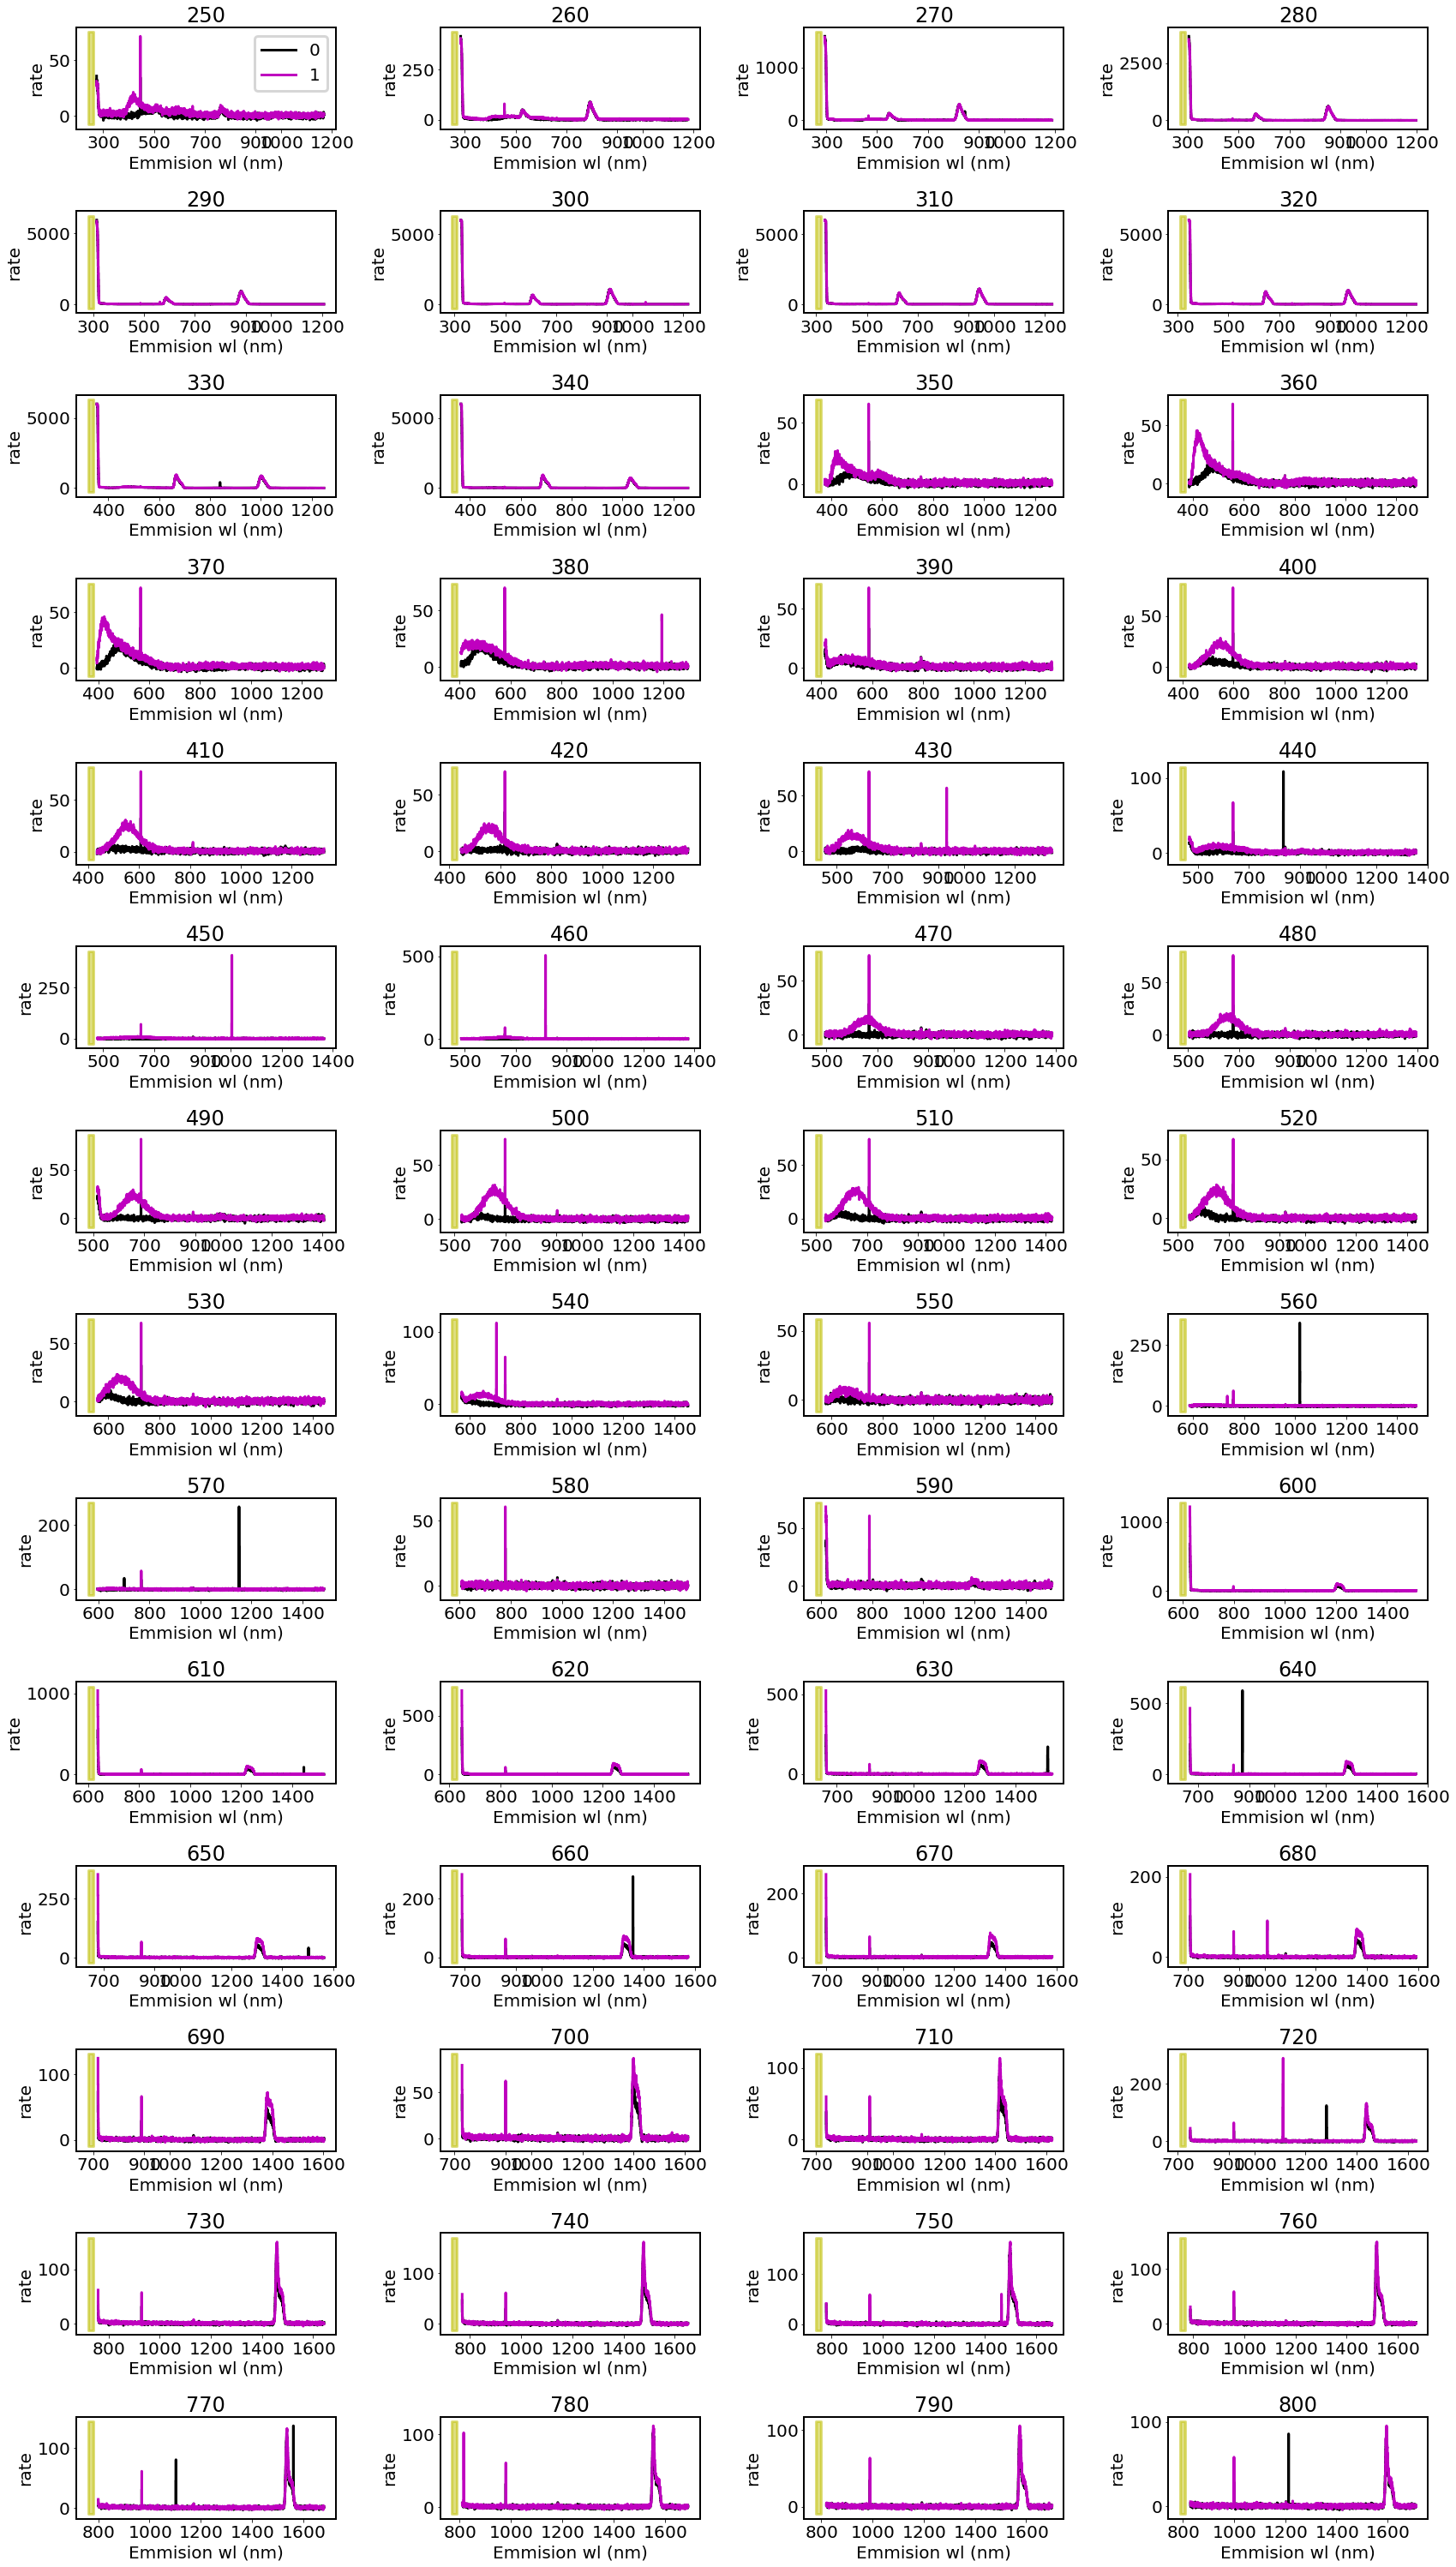

In [12]:
plot_comparison_1d_array([mgf_0, mgf_1], 10)

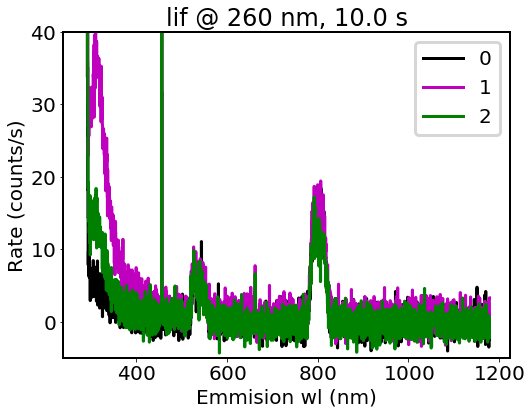

In [17]:
ex_wl = 260
exposure = 10
grating = 1 + int(ex_wl >= 400)
crystal = "lif"

dfs = sorted(filter(lambda x: x[0].startswith(crystal), crystals.items()))
dfs = list(zip(*dfs))[1]
for k, df in enumerate(dfs):
    df = filter_df(df, exposure=exposure, ex_wl=ex_wl, grating_mono = grating)
    plot1d(df.em_wl, df.rate, ylabel="Rate (counts/s)", label=str(k))

plt.title(f"{crystal} @ {ex_wl} nm, {exposure:.1f} s")
plt.ylim(-5, 40)
plt.legend()